In [2]:
# Project 4
# import packages
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from linearmodels import PanelOLS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
import eli5
from eli5.sklearn import PermutationImportance
import geopandas as gpd
import mapclassify as mc
import geoplot as gplt
import matplotlib.pyplot as plt


In [3]:
# Question 1a
mergedSummary = pd.read_csv('merged_summary.csv')

# Group by region and sum the total_observations_Focal for each region (state)
table_1_focal = mergedSummary.groupby('region').agg(
    total_observations_focal=('total_observations_Focal', 'sum')
).reset_index()
print(table_1_focal)

# Group by region and sum the total_observations_benchmark for each region (state)
table_1_benchmark = mergedSummary.groupby('region').agg(
    total_observations_benchmark=('total_observations_Benchmark', 'sum')
).reset_index()

print(table_1_benchmark)

   region  total_observations_focal
0      AL                      4529
1      AR                      3654
2      AZ                     11298
3      CA                     84903
4      CO                     20853
5      DE                      2583
6      FL                     31878
7      GA                     11662
8      IA                      1547
9      ID                       525
10     IL                     20027
11     IN                      1883
12     KS                      4788
13     KY                      5488
14     LA                     14693
15     MD                      5607
16     MI                      2569
17     MO                      5439
18     MS                      1834
19     NC                      9800
20     NE                      4067
21     NJ                      2086
22     NM                      2044
23     NY                      9121
24     OH                      9107
25     OK                      6279
26     PA                   

In [4]:
# Question 1b

# import census data
censusData = pd.read_csv('census_state_2016.csv')

# convert state names to abbreviations
state_abbreviations = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH',
    'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC',
    'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
    'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN',
    'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

censusData['state'] = censusData['state'].map(state_abbreviations)

# merge census and my data
merged_df = pd.merge(mergedSummary, censusData, left_on = 'region',
                   right_on = 'state', how = 'left')



Question 1b
mergedSummary has 62,587 observations. The census data has 52 observations (one for each state/territory). After the merge, merged_df has 62587 observations. All the observations from mergedSummary are in the census data, because the census data contains every state from mergedSummary. mergedSummary only has data for 33 states. There are 62535 observations in mergedSummary but not the census, but this is because the unit of observation is different (the census data only has data for each state, while mergedSummary has several observations per state). Since mergedSumamry only contains a sample of the population, it does not have data of the chains for all 52 states/territories. Also, there are not Wingstop or Buffalo Wild Wings locations in all states. 

In [5]:
# Question 1c
# create dependent variable
y = (np.log(merged_df['SumDailyVisits_Focal'] + 1) 
        - np.log(merged_df['SumDailyVisits_Benchmark'] + 1))

# add day of the week as a column
merged_df['exact_date'] = pd.to_datetime(merged_df['exact_date'])
merged_df['day_of_week'] = merged_df['exact_date'].dt.dayofweek

# add variable fot difference
merged_df['diff_SumDailyVisits'] = (merged_df['SumDailyVisits_Focal'] + 1) - merged_df['SumDailyVisits_Benchmark']
# make variable for if the day is a weekend
weekends = [0, 6]
merged_df['isWeekend'] = merged_df['day_of_week'].apply(
                            lambda x: 1 if x in weekends else 0)

# make a list of independent vars
dep_vars = ['day_of_week', 'male', 'white', 'citizen', 
              'total_population', 'age_over62', 'BlueState', 'isWeekend']
# get summary stats
summary_stats_dep = merged_df[dep_vars].describe()
frequency_blue = merged_df['BlueState'].value_counts()
frequency_day = merged_df['day_of_week'].value_counts()
print('Summary stats of dependent var: ')
print(summary_stats_dep)
print('\nFrequency of BlueState: ')
print(frequency_blue)
print('\nFrequency of each day of the week: ')
print(frequency_day)

merged_df.to_excel('merged_df_proj_4.xlsx')

Summary stats of dependent var: 
        day_of_week          male         white       citizen   
count  62587.000000  6.258700e+04  6.258700e+04  6.258700e+04  \
mean       3.000000  4.706522e+06  7.137269e+06  6.685349e+06   
std        2.000016  4.249340e+06  6.043891e+06  5.583283e+06   
min        0.000000  4.602320e+05  6.799630e+05  7.052090e+05   
25%        1.000000  2.179814e+06  3.120274e+06  3.342304e+06   
50%        3.000000  3.247058e+06  5.304196e+06  4.801062e+06   
75%        5.000000  5.691600e+06  9.402346e+06  8.785985e+06   
max        6.000000  1.949123e+07  2.498044e+07  2.519780e+07   

       total_population    age_over62     BlueState     isWeekend  
count      6.258700e+04  6.258700e+04  62587.000000  62587.000000  
mean       9.565587e+06  1.777884e+06      0.280282      0.285714  
std        8.590916e+06  1.525211e+06      0.449140      0.451758  
min        9.520650e+05  2.045860e+05      0.000000      0.000000  
25%        4.436974e+06  8.343710e+05    

ValueError: Excel does not support datetimes with timezones. Please ensure that datetimes are timezone unaware before writing to Excel.

In [5]:
# Question 2a
X = merged_df[['male', 'white', 'BlueState', 'isWeekend',
                'age_over62', 'total_population']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Count number of blue states in each sample
count_BlueState_train = (X_train['BlueState'] == 1).sum()
print(str(count_BlueState_train) + ' observations are blue states in the train sample.')
count_BlueState_test = (X_test['BlueState'] == 1).sum()
print(str(count_BlueState_test) + ' observations are blue states in the test sample.')

# Count number of weekends in each sample
count_isWeekend_train = (X_train['isWeekend'] == 1).sum()
print(str(count_isWeekend_train) + ' observations are weekends in the train sample.')
count_isWeekend_test = (X_test['isWeekend'] == 1).sum()
print(str(count_isWeekend_test) + ' observations are weekends in the test sample.')

13087 observations are blue states in the train sample.
4455 observations are blue states in the test sample.
13451 observations are weekends in the train sample.
4431 observations are weekends in the test sample.


Question 2a
The training sample has 46940 observations, and  the test sample has 15647 observations. 13087 observations are blue states in the train sample. 4455 observations are blue states in the test sample. 13451 observations are weekends in the train sample. 4431 observations are weekends in the test sample.

In [6]:
# Question 2b
# train regression
X2_train = sm.add_constant(X_train)
results = sm.OLS(y_train,X2_train.astype(float)).fit()
results.summary()

# test regression
X2_test = sm.add_constant(X_test)
y_pred = results.predict(X2_test)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     1647.
Date:                Sat, 20 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:34:34   Log-Likelihood:                -82475.
No. Observations:               46940   AIC:                         1.650e+05
Df Residuals:                   46933   BIC:                         1.650e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.0233      0.013    -80.352      0.000      -1.048      -0.998
male              1.337e-05   1.73e-07     77.180      0.000     1.3e-05    1.37e-05
white              -2.1e-07   8.76e-09    -23.983      0.000   -2.27e-07   -1.93e-07
BlueState           -0.0187      0.016     -1.155      0.248      -0.051       0.013
isWeekend            0.0647      0.014      4.519      0.000       0.037       0.093
age_over62        6.202e-07   2.63e-08     23.536      0.000    5.69e-07    6.72e-07
total_population -6.545e-06   8.74e-08    -74.842      0.000   -6.72e-06   -6.37e-06
==============================================================================
Omnibus:                      637.840   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              663.800
Skew:                           0.290   Prob(JB):                    7.21e-145
Kurtosis:                       3.052   Cond. No.                     4.76e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.76e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Question 2b
Coefficients:
male: 1.337e-05, significant, positive
I was not sure about the relationship between gender and Wingstop popularity, but I am not surprised that the relationship between being male and Wingstop popularity is positive, but very small. 
white: -2.1e-07, significant, negative
This number is very small, so it does not imply a strong relationship between race and Wingstop popularity. However, food like fried chicken and wings is commonly enjoyed by non-white people in the US, so I did expect that Wingstop would be less popular in areas with a lower white population.
BlueState: -0.0187, not significant, negative
isWeekend: 0.0647, significant, positive
The coefficient on weekend is significant and positive, which implies that Wingstop is more popular on weekends. I expected this, because I expect more people to eat out on weekends.
age_over62: 6.202e-07,, significant, positive
I would not have expected the population over 62 years old to have a positive relationship with Wingstop popularity, as I assume that more young people eat at fast food restaurants like Wingstop. This number is very small however.  
total_population: -6.545e-06, siginificant, negative
I would not have expected the total_population to have a negative impact on the relative popularity of Wingstop, as I would expect more people to be related with more customers. However it is a very small impact. This could be because in more popular areas, there are more food options, so maybe less people choose to eat at Wingstop. 

In [7]:
# Question 2c LASSO
# penalty parameter
print('alpha = 0.1')
linlasso = Lasso(alpha=0.1, max_iter = 10000).fit(X_train_scaled, y_train)
print('Non-zero features: {}'.format(np.sum(linlasso.coef_ != 0)))
print('R-squared score (training): {:.3f}'.format(
            linlasso.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}\n'.format(
            linlasso.score(X_test_scaled, y_test)))
print('Features with non-zero weight (sorted by absolute magnitude):')

for e in sorted (list(zip(list(X), linlasso.coef_)),
                key = lambda e: -abs(e[1])):
    if e[1] != 0:
        print('\t{}, {:.3f}'.format(e[0], e[1]))

print('\nalpha = 0.01')
linlasso2 = Lasso(alpha=0.01, max_iter = 10000).fit(X_train_scaled, y_train)
print('Non-zero features: {}'.format(np.sum(linlasso2.coef_ != 0)))
print('R-squared score (training): {:.3f}'.format(
            linlasso2.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}\n'.format(
            linlasso2.score(X_test_scaled, y_test)))
print('Features with non-zero weight (sorted by absolute magnitude):')

for e in sorted (list(zip(list(X), linlasso2.coef_)),
                key = lambda e: -abs(e[1])):
    if e[1] != 0:
        print('\t{}, {:.3f}'.format(e[0], e[1]))

print('\nalpha = 0.001')
linlasso3 = Lasso(alpha=0.001, max_iter = 10000).fit(X_train_scaled, y_train)
print('Non-zero features: {}'.format(np.sum(linlasso3.coef_ != 0)))
print('R-squared score (training): {:.3f}'.format(
            linlasso3.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}\n'.format(
            linlasso3.score(X_test_scaled, y_test)))
print('Features with non-zero weight (sorted by absolute magnitude):')

for e in sorted (list(zip(list(X), linlasso3.coef_)),
                key = lambda e: -abs(e[1])):
    if e[1] != 0:
        print('\t{}, {:.3f}'.format(e[0], e[1]))

alpha = 0.1
Non-zero features: 0
R-squared score (training): 0.000
R-squared score (test): -0.000

Features with non-zero weight (sorted by absolute magnitude):

alpha = 0.01
Non-zero features: 3
R-squared score (training): 0.031
R-squared score (test): 0.038

Features with non-zero weight (sorted by absolute magnitude):
	male, 0.965
	BlueState, 0.123
	isWeekend, 0.015

alpha = 0.001
Non-zero features: 4
R-squared score (training): 0.074
R-squared score (test): 0.085

Features with non-zero weight (sorted by absolute magnitude):
	male, 6.178
	age_over62, -4.845
	BlueState, 0.096
	isWeekend, 0.057


Question 2c
alpha = 0.001 is the best penalty parameter, because it has the largest number of non-zero features and the highest R-squared out of the three alpha options, which implies it has the strongest model. 

The features and coefficients are: 
male: 6.178
age_over62: -4.845
BlueState: 0.096
isWeekend: 0.057

4 features have non-zero coefficients, and 2 features have zero coefficients. Their signs and magnitudes are mostly very different from the previous regression. Male is still positive, but it has a much larger magnitude from before. The number of people aged over 62 is now a negative sign rather than the positive one earlier. BlueState is positve now unlike before, but it was not significant. isWeekend is a similar value and the same sign as earlier. I did not expect the amount of males and people over 62 to have such a large impact on Wingstop popularity. 

The R-squared for the test sample is 0.085. This is lower than the previous R-squared in (2b) of 0.174. 

In [8]:
# Question 2c LASSO continued
# permutation importance
perm = PermutationImportance(linlasso3).fit(X_test_scaled, y_test)
eli5.show_weights(perm)

Weight,Feature
1.7000 ± 0.0289,x0
1.1464 ± 0.0071,x4
0.0021 ± 0.0006,x2
0.0005 ± 0.0004,x3
0 ± 0.0000,x5
0 ± 0.0000,x1


Question 2c continued
The five most important features in order are:
1. male
2. age over 62
3. blue state
4. is weekend
5. total population
This is surprising to me, because before, BlueState was not significant in the linear regression model, so it is surprising that it is the third most important feature in the LASSO model. I am also surprised that isWeekend is not higher up on the list of most important features, because it had the highest coefficient in the linear regression model and it was significant. It seemed like isWeekend has the largest impact on Wingstop popularity. 

In [9]:
# Question 2d Ridge
# trying out different penalty parameters
linridge = Ridge(alpha=0.1).fit(X_train_scaled, y_train)
print('alpha = 0.1')
print('Ridge regression coef:\n{}'.format(linridge.coef_))
print('R-squared score (training): {:.3f}'.format(
            linridge.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'.format(
            linridge.score(X_test_scaled, y_test)))
print('Number of non-zero features: {}'.format(np.sum(linridge.coef_ != 0)))

linridge2 = Ridge(alpha=0.01).fit(X_train_scaled, y_train)
print('alpha=0.01')
print('Ridge regression coef:\n{}'.format(linridge2.coef_))
print('R-squared score (training): {:.3f}'.format(
            linridge2.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'.format(
            linridge2.score(X_test_scaled, y_test)))
print('Number of non-zero features: {}'.format(np.sum(linridge2.coef_ != 0)))

linridge3 = Ridge(alpha=0.001).fit(X_train_scaled, y_train)
print('alpha=0.001')
print('Ridge regression coef:\n{}'.format(linridge3.coef_))
print('R-squared score (training): {:.3f}'.format(
            linridge3.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'.format(
            linridge3.score(X_test_scaled, y_test)))
print('Number of non-zero features: {}'.format(np.sum(linridge3.coef_ != 0)))

alpha = 0.1
Ridge regression coef:
[ 1.22011582e+02 -2.94169470e+00  2.26718833e-02  6.33457491e-02
 -9.20359869e-01 -1.16089155e+02]
R-squared score (training): 0.145
R-squared score (test): 0.155
Number of non-zero features: 6
alpha=0.01
Ridge regression coef:
[ 2.29240761e+02 -4.69210522e+00 -1.08614498e-02  6.44366232e-02
  3.03207032e+00 -2.24971060e+02]
R-squared score (training): 0.173
R-squared score (test): 0.180
Number of non-zero features: 6
alpha=0.001
Ridge regression coef:
[ 2.51750373e+02 -5.05868534e+00 -1.78629343e-02  6.46657571e-02
  3.86228511e+00 -2.47829129e+02]
R-squared score (training): 0.174
R-squared score (test): 0.180
Number of non-zero features: 6


Question 2d
alpha = 0.001 is the best penalty parameter, because it has the highest R-squared out of the three alpha options, which implies it has the strongest model. 
['male', 'white', 'BlueState', 'isWeekend',
                'age_over62', 'total_population']

There are no zero feature coefficients, and 6 non-zero coefficients (all of them). The coefficients are:
male: 2.51750373e+02, positive
This coefficient is consistent with the previous results. The magnitude is in between the linear and LASSO models, and the sign is the same.
white: -5.05868534e+00, negative
This coefficient is consistent with the initial linear regression, as it is negative, although it has a higher magnitude. Unlike the LASSO model, this coefficent is not zero. 
BlueState: -1.78629343e-02, negative 
This coefficient is consistent with the linear regression model, although in that model it was not significant. The sign is different from the LASSO model, but the magnitude is not that different.  
isWeekend: 6.46657571e-02, positive
This coefficient is consistent with all of my estimates, as it is positive and has a similar magnitude. 
age_over62: 3.86228511e+00, positive 
This coefficient is the same in sign as my initial regression, although it has a larger magnitude. The sign is different from the LASSO regression. 
total_population: -2.47829129e+02, negative
The sign is consistend with my initial regression, although it has a larger magnitude. This coefficient was zero in the LASSO model. 

The R-squared for Ridge is 0.180. This is the largest R-squared out of all the models, although it is not much higher than the linear regression. 

In [10]:
# Question 2d Ridge continued
# permutations
perm = PermutationImportance(linridge3).fit(X_test_scaled, y_test)
eli5.show_weights(perm)

Weight,Feature
2734.3645 ± 28.7134,x0
2672.1362 ± 35.9250,x5
1.3650 ± 0.0312,x1
0.7395 ± 0.0251,x4
0.0006 ± 0.0008,x3
-0.0001 ± 0.0001,x2


The five most important features are: 
1. male 
2. total population
3. white
4. age over 62
5. is weekend
The five most important features are different than LASSO, as white is in the top five here, but not blue state. This is interesting because these were the significant variables in my linear regression. I did expect isWeekend to be higher on the list because it had the largest impact in the linear regression. White being important is consistent with the linear regression. 

In [6]:
# Find ridge optimal alpha
n_alphas = 50
alphas = np.logspace(-5, 2, n_alphas)
linridge_cv = RidgeCV(alphas=alphas).fit(X_train_scaled, y_train)
linridge_cv.alpha_

NameError: name 'X_train_scaled' is not defined

C:\Users\marya\AppData\Local\Temp\ipykernel_37024\961430126.py:15: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  geoData = geoData.explode()
C:\Users\marya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mapclassify\classifiers.py:1592: UserWarning: Not enough unique values in array to form 10 classes. Setting k to 1.
  self.bins = quantile(y, k=k)
C:\Users\marya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\marya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-package

ValueError: zero-size array to reduction operation minimum which has no identity

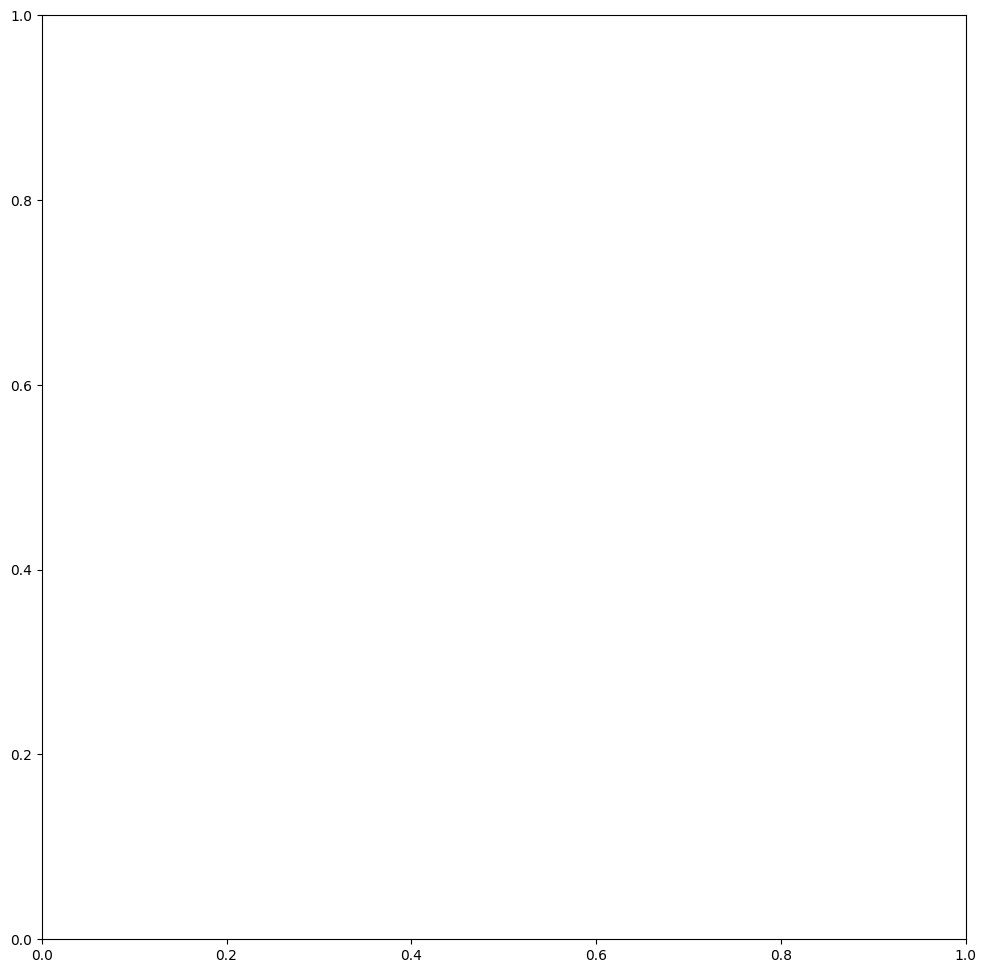

In [27]:
# Calculate average dailyvisits by region
region_ = merged_df[['SumDailyVisits_Focal', 'region']].groupby(['region']).mean()
region_.reset_index(inplace = True)
region_